In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

PATH = r"D:\ECG_delineation\mit-bih-arrhythmia-database-1.0.0\mit-bih-arrhythmia-database-1.0.0"     #path, 这里就是写保存的数据地址  
HEADERFILE = "100.hea"     #文件格式为文本格式 
ATRFILE = "100.atr"     #attributes-file 文件以二进制格式 
DATAFILE = "100.dat"     #data-file  

####################读取头文件######################
f = open(os.path.join(PATH, HEADERFILE), "r")
z = f.readline().split()
nosig, sfreq = int(z[1]), int(z[2])     #% number of signals，sample rate of data
SAMPLES2READ = 10 * sfreq     #读取的数据样本点数

dformat, gain, bitres, zerovalue, firstvalue = [], [], [], [], []
for i in range(nosig):
    z = f.readline().split()
    dformat.append(int(z[1]))     #format; here only 212 is allowed
    gain.append(int(z[2]))     #number of integers per mV
    bitres.append(int(z[3]))     #bitresolution
    zerovalue.append(int(z[4]))     #integer value of ECG zero point
    firstvalue.append(int(z[5]))     #first integer value of signal (to test for errors)
f.close()

####################读取dat文件######################
#.dat文件的数据格式读取为每行三个字节,即三个八位的二进制数字,其内容含义为
#      0000 0000  ||             0000 0000              ||  0000 0000
#sign1(L)低八位信息||左四位sign2(R),右四位sign1(L)||sign2(R)低八位信息
#将第二字节的信息处理后,后四位移至第一字节最左位即得到完整的sign1
#将第二字节的信息处理后,前四位移至第一字节最左位即得到完整的sign2.

f = open(os.path.join(PATH, DATAFILE), "rb")     #以二进制格式读入dat文件
b = f.read()   
f.close()

A_init = np.frombuffer(b,dtype=np.uint8)      #将读入的二进制文件转化为unit8格式
A_shape0 = int(A_init.shape[0]/3)     
A = A_init.reshape(A_shape0, 3)[:SAMPLES2READ]     #将A转为3列矩阵

M = np.zeros((SAMPLES2READ, 2))     #创建矩阵M

M2H = A[:, 1]>>4     #字节向右移四位，即取字节的高四位
M1H = A[:, 1]&15     #取字节的低四位

PRL = (A[:, 1]&8)*(2**9)     #sign-bit   取出字节低四位中最高位，向左移九位，等于乘2^9
PRR = A[:, 1]&128<<5     #sign-bit   取出字节高四位中最高位，向左移五位

M1H = M1H * (2**8)
M2H = M2H * (2**8)

M[:,0] = A[:,0]+M1H-PRL
M[:,1] = A[:,2]+M2H-PRR

if ((M[1,:]!=firstvalue).any()):
    print("inconsistency in the first bit values")

if nosig==2:
    M[:, 0] = (M[:, 0] - zerovalue[0]) / gain[0]
    M[:, 1] = (M[:, 1] - zerovalue[1]) / gain[1]
    TIME=np.linspace(0,SAMPLES2READ-1,SAMPLES2READ)/sfreq
elif nosig==1:
    M2=[]
    M[:, 0] = M[:, 0] - zerovalue[0]
    M[:, 1] = M[:, 1] - zerovalue[1]
    for i in range(M.shape[0]):
        M2.append(M[:,0][i])
        M2.append(M[:,1][i])
    M2.append(0)
    del M2[0]
    M2 = np.array(M2)/gain[0]
    TIME = np.linspace(0,2*SAMPLES2READ-1,2*SAMPLES2READ)/sfreq
else:
    print("Sorting algorithm for more than 2 signals not programmed yet!")

####################读取atr文件######################
f=open(os.path.join(PATH, ATRFILE), "rb")     #主要是读取ATR文件中各周期数据并在之后打印在图中
b=f.read()
f.close()

A_init=np.frombuffer(b,dtype=np.uint8)
A_shape0=int(A_init.shape[0]/2)
A=A_init.reshape(A_shape0,2)

ANNOT,ATRTIME=[],[]
i=0
while i < A.shape[0]:
    annoth=A[i,1]>>2
    if annoth==59:
        ANNOT.append(A[i+3,1]>>2)
        ATRTIME.append(A[i+2,0]+A[i+2,1]*(2**8)+A[i+1,0]*(2**16)+A[i+1,1]*(2**24))
        i+=3
    elif annoth==60:pass
    elif annoth==61:pass
    elif annoth==62:pass
    elif annoth==63:
        hilfe=(A[i,1]&3)*(2**8)+A[i,0]
        hilfe=hilfe+hilfe%2
        i+=int(hilfe/2)
    else:
        ATRTIME.append((A[i,1]&3)*(2**8)+A[i,0])
        ANNOT.append(A[i,1]>>2)
    i+=1

del ANNOT[len(ANNOT)-1]
del ATRTIME[len(ATRTIME)-1]

ATRTIME=np.array(ATRTIME)
ATRTIME=np.cumsum(ATRTIME)/sfreq

ind=np.where(ATRTIME<=TIME[-1])[0]
ATRTIMED=ATRTIME[ind]

ANNOT=np.round(ANNOT)
ANNOTD=ANNOT[ind]

sample rate of data: 360Hz


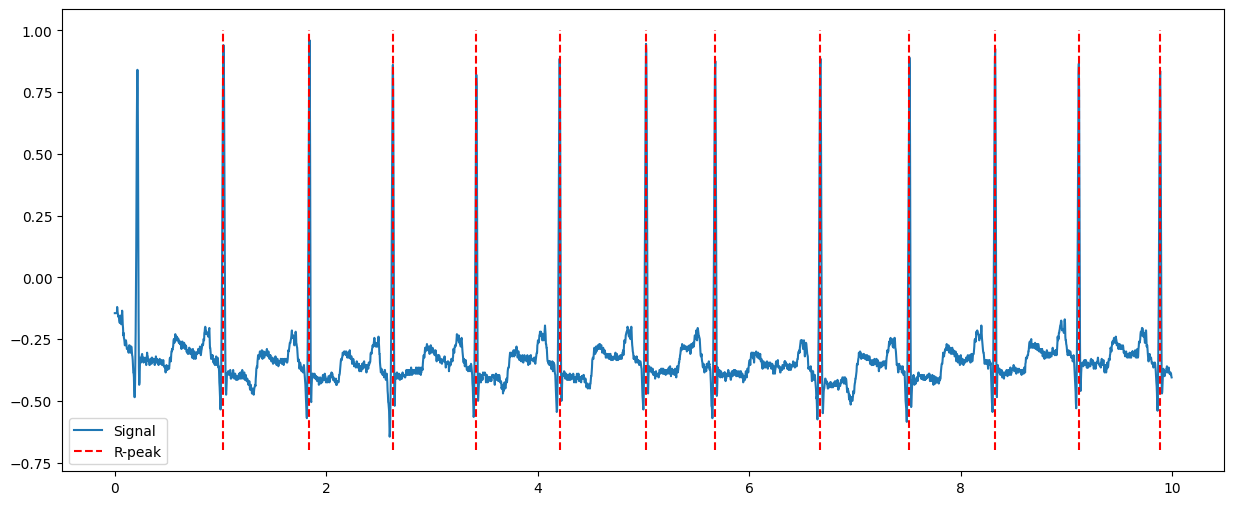

In [2]:
import neurokit2 as nk

# 抓取R-peak
ecg_signal = M[:, 0]
_, rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=sfreq)
print("sample rate of data: %dHz"%sfreq)

# 繪製圖形
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(TIME, M[:, 0], label='Signal')
ax.vlines(rpeaks['ECG_R_Peaks'] / sfreq, -0.7, 1, linestyles='dashed', colors='red', label='R-peak')
ax.legend(loc='lower left')

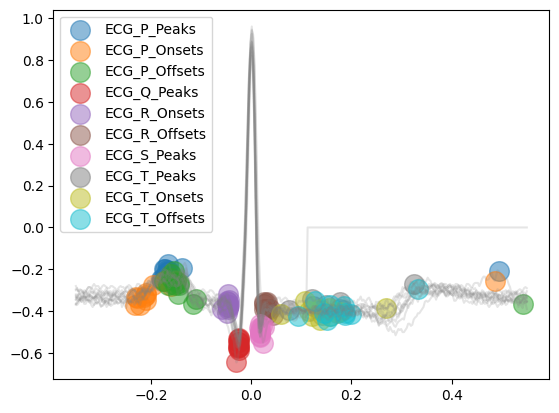

In [3]:
# Delineate the ECG signal
signal_dwt, waves_dwt = nk.ecg_delineate(ecg_signal, 
                                         rpeaks, 
                                         sampling_rate=sfreq, 
                                         method="dwt", 
                                         show=True, 
                                         show_type='all')

In [4]:
waves_dwt

{'ECG_P_Peaks': [308,
  602,
  883,
  1166,
  1465,
  1746,
  1986,
  2346,
  2642,
  2937,
  3223,
  3499],
 'ECG_P_Onsets': [299,
  587,
  863,
  1149,
  1461,
  1726,
  1983,
  2345,
  2626,
  2921,
  3207,
  3484],
 'ECG_P_Offsets': [312,
  611,
  887,
  1168,
  1475,
  1751,
  2003,
  2350,
  2651,
  2944,
  3227,
  3508],
 'ECG_Q_Peaks': [360,
  654,
  936,
  1222,
  1505,
  1800,
  2035,
  2393,
  2697,
  2989,
  3274,
  nan],
 'ECG_R_Onsets': [352,
  646,
  926,
  1215,
  1498,
  1792,
  2027,
  2385,
  2689,
  2982,
  3266,
  nan],
 'ECG_R_Offsets': [383,
  673,
  956,
  1242,
  1525,
  1819,
  2054,
  2418,
  2717,
  3007,
  3294,
  nan],
 'ECG_S_Peaks': [379,
  669,
  953,
  1237,
  1521,
  1816,
  2050,
  2411,
  2712,
  3004,
  3289,
  nan],
 'ECG_T_Peaks': [433,
  712,
  1063,
  1258,
  1576,
  1862,
  2089,
  2453,
  2771,
  3061,
  3326,
  nan],
 'ECG_T_Onsets': [431,
  706,
  1043,
  1252,
  1571,
  1858,
  2086,
  2452,
  2769,
  3053,
  3321,
  nan],
 'ECG_T_Offsets'

In [5]:
class ECG_function:
    def detectAmplitude(self, ecg_signal, Peak, wave_type):
        wave_type = wave_type.upper()
        if wave_type not in ['P', 'T', 'R']:
            raise ValueError("wave_type must be P、T、R")
        
        Peak = np.array(Peak)
        mask = ~np.isnan(Peak)
        Peak = Peak[mask]
        Value = []
        for i in Peak:
            Value.append(ecg_signal[int(i)])
        
        Value = np.array(Value)
        mean = np.mean(Value)
        std = np.std(Value)
        
        mydict = {
            wave_type + '_mask': mask, 
            wave_type + '_Peak': Peak, 
            wave_type + '_Value': Value, 
            wave_type + '_mean': mean, 
            wave_type + '_std': std
        }
        
        return mydict
    
    def detectDuration(self, _on, _off, wave_type, sfreq):
        wave_type = wave_type.upper()
        mask = ~(np.isnan(_on) | np.isnan(_off))
        _on = np.array(_on)[mask] / sfreq
        _off = np.array(_off)[mask] / sfreq
        _duration = _off - _on
        _mean = np.mean(_duration)
        _std = np.std(_duration)
        
        mydict = {
            wave_type + '_mask': mask, 
            wave_type + '_on': _on, 
            wave_type + '_off': _off, 
            wave_type + '_duration': _duration, 
            wave_type + '_mean': _mean, 
            wave_type + '_std': _std
        }
        
        return mydict

In [6]:
test = ECG_function()

In [7]:
test.detectAmplitude(ecg_signal, waves_dwt['ECG_T_Peaks'], 'T')

{'T_mask': array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False]),
 'T_Peak': array([ 433.,  712., 1063., 1258., 1576., 1862., 2089., 2453., 2771.,
        3061., 3326.]),
 'T_Value': array([-0.39 , -0.395, -0.27 , -0.395, -0.41 , -0.37 , -0.375, -0.42 ,
        -0.395, -0.355, -0.34 ]),
 'T_mean': -0.3740909090909091,
 'T_std': 0.03970448691258628}

In [8]:
test.detectDuration(waves_dwt['ECG_R_Onsets'], waves_dwt['ECG_R_Offsets'], 'QRS', sfreq)

{'QRS_mask': array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False]),
 'QRS_on': array([0.97777778, 1.79444444, 2.57222222, 3.375     , 4.16111111,
        4.97777778, 5.63055556, 6.625     , 7.46944444, 8.28333333,
        9.07222222]),
 'QRS_off': array([1.06388889, 1.86944444, 2.65555556, 3.45      , 4.23611111,
        5.05277778, 5.70555556, 6.71666667, 7.54722222, 8.35277778,
        9.15      ]),
 'QRS_duration': array([0.08611111, 0.075     , 0.08333333, 0.075     , 0.075     ,
        0.075     , 0.075     , 0.09166667, 0.07777778, 0.06944444,
        0.07777778]),
 'QRS_mean': 0.0782828282828283,
 'QRS_std': 0.006018371357481292}